<a href="https://colab.research.google.com/github/nidjosep/student-feedback-analysis/blob/master/Bag_Of_Words_Approach_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importing the Required Libraries

In [1]:
#Importing the required libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import words, stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

#2. Dataset Selection

The Dataset we have selected for the first model is 100K Coursera's Course Reviews Dataset : https://www.kaggle.com/datasets/septa97/100k-courseras-course-reviews-dataset

This dataset contains reviews by students for Coursera courses and their corresponding star ratings.

Data Format: (
  Id - The unique identifier for a review,
  Review - The actual course review,
  Label - The rating of the course review)

We believe that this dataset best represents the input data for our problem as it is actual reviews given by students on different courses.


In [2]:
# Mounting the Google Drive
drive.mount('/content/drive', force_remount=True)

# Loading the dataset stored in the drive
df = pd.read_csv('/content/drive/MyDrive/ML/reviews.csv')

Mounted at /content/drive


In [3]:
df.head(10)

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4
5,5,"Great course - I recommend it for all, especia...",5
6,6,One of the most useful course on IT Management!,5
7,7,I was disappointed because the name is mislead...,3
8,8,Super content. I'll definitely re-do the course,5
9,9,One of the excellent courses at Coursera for i...,5


# Data Preprocessing

The data_preprocessing function is designed to clean and prepare text data within a DataFrame. It includes essential text processing steps: first, downloading necessary NLTK resources like stopwords and English words corpus. Then, it defines functions to remove stopwords, non-English words, and non-alphabetic characters from text. Within the function, if an 'Id' column exists, it's dropped. If a 'Review' column exists, various cleaning operations are performed on it: removing hashtags, mentions, and URLs using regex patterns, converting text to lowercase, and eliminating stopwords. Overall, this function orchestrates a series of text cleaning processes, ensuring the resulting DataFrame is ready for subsequent analysis or machine learning tasks by enhancing text quality and reducing noise.

In [4]:
def data_preprocessing(df):

    nltk.download('stopwords')
    nltk.download('words')
    english_words = set(words.words())

    # Function to remove stop words
    def remove_stop_words(text):
      stop_words = set(stopwords.words('english')) # Load stop words
      words_to_remove = ['not', 'nor', 'neither'] # words to remove from the stop words
      for word in words_to_remove:
              if word in stop_words:
                  stop_words.remove(word) # excluding the removal of context words.
      return ' '.join([word for word in text.split() if word.lower() not in stop_words])

    #Function to remove non english words from the dataset
    def remove_non_english_words(text):
       return ' '.join(word for word in text.split() if word.lower() in english_words)

    # Function to remove non_alphabetic characters
    def remove_non_alphabetic(text):
      non_alphabetic_pattern = re.compile(r'[^a-zA-Z\s]')  # Keep only alphabetic characters and whitespace
      return non_alphabetic_pattern.sub('', text)

    def convert_labels(label):
      if label in [1, 2]:
          return 1
      elif label == 3:
          return 2
      else:
          return 3



    if 'Id' in df.columns:
      df.drop(columns=['Id'],inplace=True) #dropping the "Id" coloumn.

    if 'Review' in df.columns:

      df['Review'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True) #remove hashtags

      df['Review'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True) #Remove Mention

      df['Review'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True) #Remove URL

      df['Review']=df['Review'].str.lower() #all characters to lowercase

      df['Review'] = df['Review'].apply(remove_stop_words) # remove the stopwords

      # df['Review'] = df['Review'].apply(remove_non_english_words) # remove the non english words

      # df['Review'] = df['Review'].apply(remove_non_alphabetic) # remove the non alphabetic characters



    return df

df = data_preprocessing(df)
df.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


,Review,Label
0,good interesting,5
1,"class helpful me. currently, i'm still learnin...",5
2,like!prof tas helpful discussion among student...,5
3,easy follow includes lot basic important techn...,5
4,really nice teacher!i could got point eazliy v,4
5,"great course - recommend all, especially busin...",5
6,one useful course management!,5
7,disappointed name misleading. course provides ...,3
8,super content. i'll definitely re-do course,5
9,one excellent courses coursera information tec...,5


# Input Data Formatting

The function bag_of_words is designed to convert text data into
a numerical format suitable for machine learning models using a bag-of-words representation. Depending on whether it's for training or prediction, it employs either CountVectorizer or TfidfVectorizer from the sklearn.feature_extraction.text module to transform the text into numerical matrices. For training, it constructs a corpus from the provided DataFrame, converts it into a numerical matrix with the chosen vectorizer, and creates a DataFrame representation of the bag-of-words. If class labels are provided, it integrates them into the resulting DataFrame. For prediction, it utilizes pre-existing vectorizer data to transform input text into a numerical matrix, forming a DataFrame akin to the training scenario. The function returns the transformed DataFrame and the vectorizer object used, allowing seamless application and potential reuse for machine learning tasks involving text data.

In [5]:
def bag_of_words(df,x_col_name,y_col_name=None,is_prediction=False,vectorizer_data = None):
  from sklearn.model_selection import train_test_split
  from sklearn.feature_extraction.text import CountVectorizer

  x = df[x_col_name]
  if(is_prediction == False):
     y = df[y_col_name]

  if is_prediction ==  True:
    vocabulary_data = vectorizer_data.transform(x)
    word_bag = pd.DataFrame(vocabulary_data.toarray(), columns = vectorizer_data.get_feature_names_out())

  else :

    # Creating a word corpus for vectorization
    corpus = []
    for i in range(x.shape[0]):
        corpus.append(x.iloc[i])


    vectorizer_data = CountVectorizer(max_features=8000)
    vocabulary_data = vectorizer_data.fit_transform(corpus)
    word_bag = pd.DataFrame(vocabulary_data.toarray(), columns = vectorizer_data.get_feature_names_out())
    if(is_prediction == False):
      word_bag['class_label']=df[y_col_name]

  return word_bag,vectorizer_data

word_bag,vectorizer_data= bag_of_words(df,"Review","Label",False)
word_bag.head()


,00,000,01,10,100,1000,101,11,12,13,...,yu,zelikow,zero,zip,zmot,zombies,zone,감사합니다,고맙습니다,class_label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


The function train_data_formatting prepares training data for machine learning models by formatting the input features and labels from a DataFrame df. It imports the to_categorical function from Keras to convert the class labels to one-hot encoded format. The function separates the 'class_label' column from the DataFrame as the target variable and the remaining columns as input features ('word_bag_train'). It converts the class labels to one-hot encoded vectors and arranges the input features and encoded labels into arrays. Finally, it returns the formatted training data in 'word_bag_train' and 'y_train_encoded' for subsequent use in training machine learning models. The provided example then applies this function to prepare training data from the 'word_bag' DataFrame.

In [6]:
def train_test_split(df):
    from keras.utils import to_categorical

    # Separate data into respective class labels
    class_data = {}
    for label in range(6):
        class_data[label] = df[df.class_label == label]

    # Split data into train and test sets for each class label
    train_data = {}
    test_data = {}
    for label in range(6):
        train_data[label] = class_data[label].sample(frac=0.8, random_state=0)
        test_data[label] = class_data[label].drop(train_data[label].index)

    # Concatenate train and test sets for all class labels
    train_set = pd.concat(train_data.values(), axis=0)
    test_set = pd.concat(test_data.values(), axis=0)

    # Extract features and labels for train and test sets
    word_bag_train = train_set.drop(['class_label'], axis=1)
    y_train = list(train_set.class_label)
    word_bag_test = test_set.drop(['class_label'], axis=1)
    y_test = list(test_set.class_label)

    # Convert labels to one-hot encoded format
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # Convert to numpy arrays
    word_bag_train, y_train = np.array(word_bag_train), np.array(y_train)
    word_bag_test, y_test = np.array(word_bag_test), np.array(y_test)

    return word_bag_train, y_train_encoded, word_bag_test, y_test_encoded


word_bag_train, y_train_encoded, word_bag_test, y_test_encoded = train_test_split(word_bag)

# Model Selection

For the model selection, we have used a combination of the Bag of Words and Neural Networks techniques. The fusion of the Bag of Words (BoW) technique with neural networks constitutes a robust approach in natural language processing for text classification. BoW involves converting text into numerical representations by counting word occurrences, offering a simple yet effective way to encode text data. Pairing this with neural networks allows the model to learn complex patterns and relationships within these encoded representations, empowering it to classify text accurately. This combined approach leverages BoW's ability to capture word frequency information and the neural network's capacity to discern intricate patterns, making it a potent solution for tasks like sentiment analysis, topic classification, or spam detection, offering a balance between interpretability and predictive power. Adjusting the network architecture and preprocessing steps can enhance its performance for diverse text classification challenges.

The bag of words vector is stored in the variable "word_bag_train". It is given as an input to the layered neural network.



In [7]:


def plot_graph(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()


# Model Architecture Experiments

Experimenting with different Dense Layer architectures to get the right model.

In [ ]:


model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

In [ ]:
# Trying out different model architecture

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=64,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

# Hyperparameter optimization

Here we have selected the 4 Dense layer model as it has a good amount of right predictions when we tested and the graph is comparatively better for Model Accuracy and the Model loss is just at the border.

Applying different hyper parameter changes to find an optimal model.

##Changing the Learning Rate

Epoch 1/30
2408/2408 [==============================] - 14s 5ms/step - loss: 0.8150 - accuracy: 0.7186 - val_loss: 0.2322 - val_accuracy: 0.9782
Epoch 2/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.6376 - accuracy: 0.7536 - val_loss: 0.2311 - val_accuracy: 0.9529
Epoch 3/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.5971 - accuracy: 0.7703 - val_loss: 0.2459 - val_accuracy: 0.9393
Epoch 4/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.5643 - accuracy: 0.7822 - val_loss: 0.2392 - val_accuracy: 0.9374
Epoch 5/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.5315 - accuracy: 0.7956 - val_loss: 0.2244 - val_accuracy: 0.9395
Epoch 6/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.4973 - accuracy: 0.8103 - val_loss: 0.2251 - val_accuracy: 0.9353


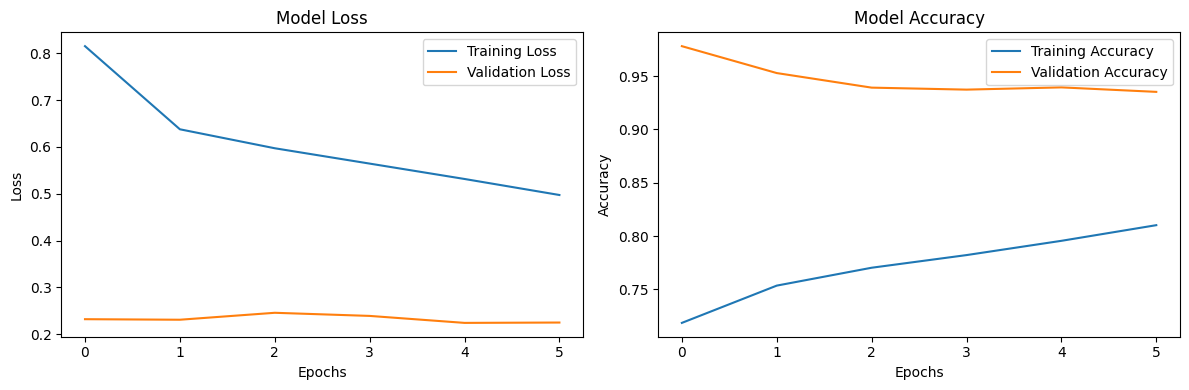

In [18]:
# Learning rate 0.0001
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

Epoch 1/30
2408/2408 [==============================] - 15s 5ms/step - loss: 0.6706 - accuracy: 0.7481 - val_loss: 0.1835 - val_accuracy: 0.9597
Epoch 2/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.5571 - accuracy: 0.7844 - val_loss: 0.2293 - val_accuracy: 0.9487
Epoch 3/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.4517 - accuracy: 0.8262 - val_loss: 0.2003 - val_accuracy: 0.9458
Epoch 4/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.3445 - accuracy: 0.8727 - val_loss: 0.3180 - val_accuracy: 0.9137
Epoch 5/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.2693 - accuracy: 0.9032 - val_loss: 0.4609 - val_accuracy: 0.8777
Epoch 6/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.2149 - accuracy: 0.9253 - val_loss: 0.4593 - val_accuracy: 0.8929


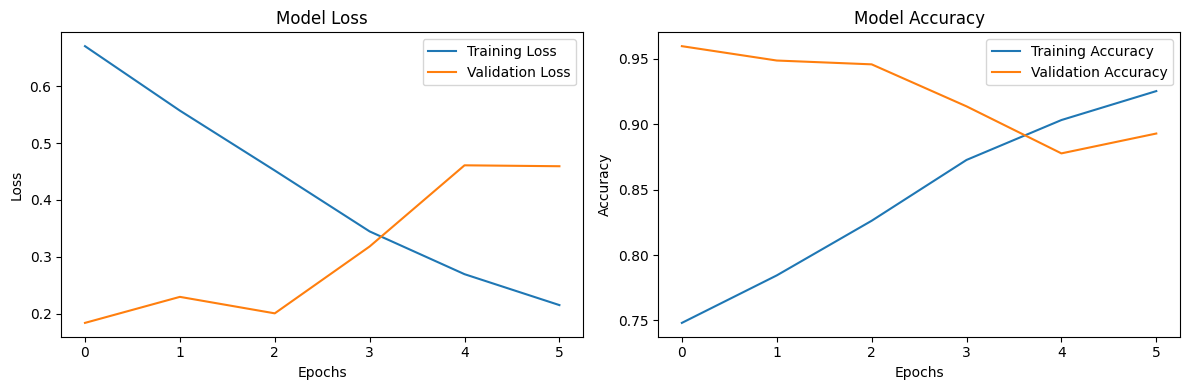

In [10]:
# Changing the learning rate to 0.005

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

Epoch 1/30
2408/2408 [==============================] - 14s 5ms/step - loss: 0.6770 - accuracy: 0.7487 - val_loss: 0.2031 - val_accuracy: 0.9657
Epoch 2/30
2408/2408 [==============================] - 10s 4ms/step - loss: 0.5524 - accuracy: 0.7883 - val_loss: 0.2216 - val_accuracy: 0.9576
Epoch 3/30
2408/2408 [==============================] - 11s 4ms/step - loss: 0.4390 - accuracy: 0.8349 - val_loss: 0.2879 - val_accuracy: 0.9276
Epoch 4/30
2408/2408 [==============================] - 10s 4ms/step - loss: 0.3190 - accuracy: 0.8854 - val_loss: 0.2766 - val_accuracy: 0.9297
Epoch 5/30
2408/2408 [==============================] - 10s 4ms/step - loss: 0.2303 - accuracy: 0.9202 - val_loss: 0.4110 - val_accuracy: 0.8983
Epoch 6/30
2408/2408 [==============================] - 10s 4ms/step - loss: 0.1737 - accuracy: 0.9405 - val_loss: 0.3728 - val_accuracy: 0.9260


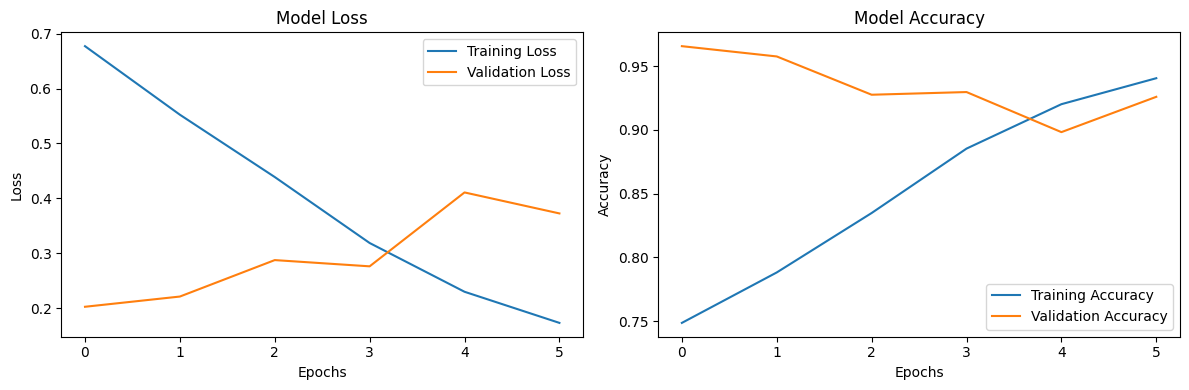

In [8]:
# Changing the learning rate to 0.001

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

We find that the learning rate of 0.01 best works for our test dataset due to the loss and accuracy being optimal.

## Changing the Activation Function

Epoch 1/30
2408/2408 [==============================] - 15s 5ms/step - loss: 0.6680 - accuracy: 0.7485 - val_loss: 0.2423 - val_accuracy: 0.9594
Epoch 2/30
2408/2408 [==============================] - 11s 4ms/step - loss: 0.5670 - accuracy: 0.7814 - val_loss: 0.2103 - val_accuracy: 0.9601
Epoch 3/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.5000 - accuracy: 0.8076 - val_loss: 0.2601 - val_accuracy: 0.9395
Epoch 4/30
2408/2408 [==============================] - 11s 4ms/step - loss: 0.4342 - accuracy: 0.8346 - val_loss: 0.2974 - val_accuracy: 0.9221
Epoch 5/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.3758 - accuracy: 0.8591 - val_loss: 0.2851 - val_accuracy: 0.9258
Epoch 6/30
2408/2408 [==============================] - 11s 4ms/step - loss: 0.3235 - accuracy: 0.8797 - val_loss: 0.3732 - val_accuracy: 0.8941
Epoch 7/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.2809 - accuracy: 0.8977 - val_loss: 0.3758 - val_ac

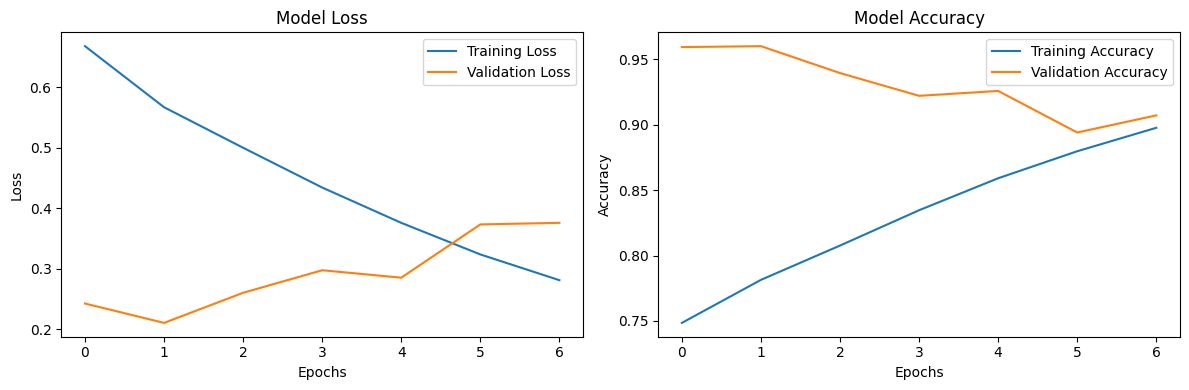

In [8]:
# Changing the activation function to elu

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='elu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

Epoch 1/30
2408/2408 [==============================] - 14s 5ms/step - loss: 0.6665 - accuracy: 0.7486 - val_loss: 0.2069 - val_accuracy: 0.9660
Epoch 2/30
2408/2408 [==============================] - 11s 4ms/step - loss: 0.5765 - accuracy: 0.7789 - val_loss: 0.2201 - val_accuracy: 0.9566
Epoch 3/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.5201 - accuracy: 0.8015 - val_loss: 0.2430 - val_accuracy: 0.9470
Epoch 4/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.4630 - accuracy: 0.8249 - val_loss: 0.2770 - val_accuracy: 0.9249
Epoch 5/30
2408/2408 [==============================] - 11s 4ms/step - loss: 0.4050 - accuracy: 0.8508 - val_loss: 0.2504 - val_accuracy: 0.9297
Epoch 6/30
2408/2408 [==============================] - 11s 5ms/step - loss: 0.3525 - accuracy: 0.8725 - val_loss: 0.2722 - val_accuracy: 0.9206


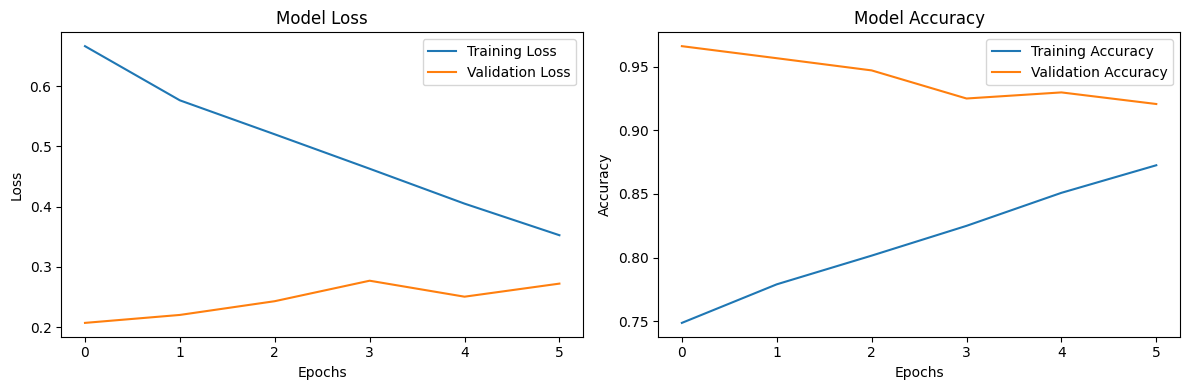

In [12]:
# Changing the  activation function to tanh

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=32,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

From the above test, we can infer that relu works best with our dataset and model.

## Changing the Batch Size

Epoch 1/30
268/268 [==============================] - 7s 23ms/step - loss: 0.8418 - accuracy: 0.7044 - val_loss: 0.2685 - val_accuracy: 0.9503
Epoch 2/30
268/268 [==============================] - 3s 13ms/step - loss: 0.6431 - accuracy: 0.7377 - val_loss: 0.3180 - val_accuracy: 0.9189
Epoch 3/30
268/268 [==============================] - 3s 12ms/step - loss: 0.5576 - accuracy: 0.7788 - val_loss: 0.2742 - val_accuracy: 0.9257
Epoch 4/30
268/268 [==============================] - 3s 12ms/step - loss: 0.4643 - accuracy: 0.8218 - val_loss: 0.2439 - val_accuracy: 0.9337
Epoch 5/30
268/268 [==============================] - 3s 13ms/step - loss: 0.3637 - accuracy: 0.8667 - val_loss: 0.3385 - val_accuracy: 0.8972
Epoch 6/30
268/268 [==============================] - 3s 12ms/step - loss: 0.2772 - accuracy: 0.9022 - val_loss: 0.3486 - val_accuracy: 0.8950


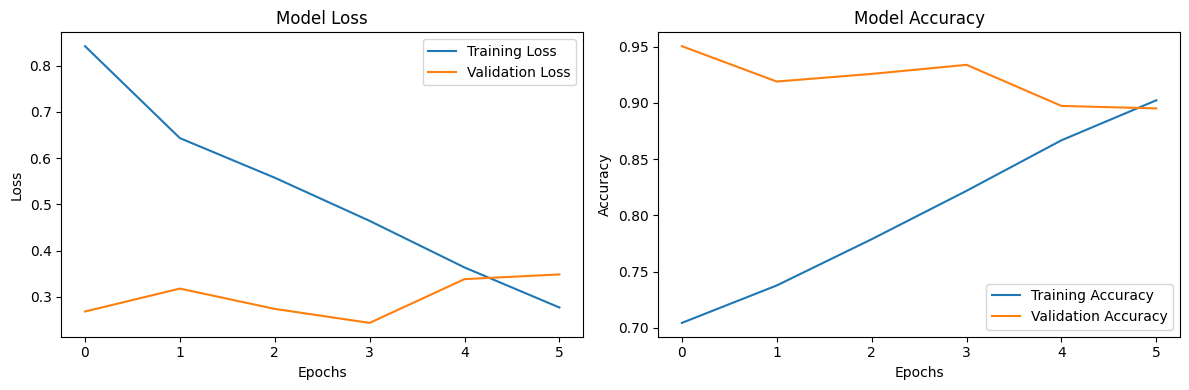

In [11]:
# Changing the  batch size to 256

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=256,validation_split=0.2,callbacks=[early_stopping])
plot_graph(history)

Epoch 1/30
602/602 [==============================] - 7s 10ms/step - loss: 0.7217 - accuracy: 0.7419 - val_loss: 0.2401 - val_accuracy: 0.9521
Epoch 2/30
602/602 [==============================] - 4s 7ms/step - loss: 0.5589 - accuracy: 0.7834 - val_loss: 0.2601 - val_accuracy: 0.9427
Epoch 3/30
602/602 [==============================] - 4s 7ms/step - loss: 0.4642 - accuracy: 0.8243 - val_loss: 0.2946 - val_accuracy: 0.9227
Epoch 4/30
602/602 [==============================] - 5s 8ms/step - loss: 0.3528 - accuracy: 0.8730 - val_loss: 0.3374 - val_accuracy: 0.9034
Epoch 5/30
602/602 [==============================] - 4s 7ms/step - loss: 0.2574 - accuracy: 0.9112 - val_loss: 0.3805 - val_accuracy: 0.8958
Epoch 6/30
602/602 [==============================] - 4s 7ms/step - loss: 0.1935 - accuracy: 0.9349 - val_loss: 0.3394 - val_accuracy: 0.9283


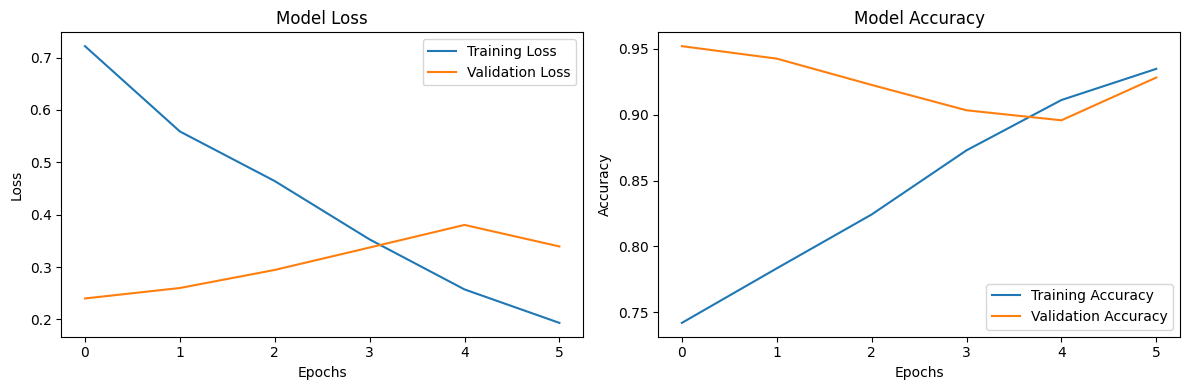

In [13]:
# Changing the  batch size to 128
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=128,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

Epoch 1/30
1204/1204 [==============================] - 9s 7ms/step - loss: 0.6906 - accuracy: 0.7465 - val_loss: 0.2040 - val_accuracy: 0.9589
Epoch 2/30
1204/1204 [==============================] - 7s 5ms/step - loss: 0.5452 - accuracy: 0.7905 - val_loss: 0.2020 - val_accuracy: 0.9588
Epoch 3/30
1204/1204 [==============================] - 6s 5ms/step - loss: 0.4269 - accuracy: 0.8415 - val_loss: 0.1891 - val_accuracy: 0.9521
Epoch 4/30
1204/1204 [==============================] - 7s 6ms/step - loss: 0.3026 - accuracy: 0.8930 - val_loss: 0.3023 - val_accuracy: 0.9098
Epoch 5/30
1204/1204 [==============================] - 7s 5ms/step - loss: 0.2165 - accuracy: 0.9256 - val_loss: 0.3515 - val_accuracy: 0.9060
Epoch 6/30
1204/1204 [==============================] - 7s 5ms/step - loss: 0.1641 - accuracy: 0.9447 - val_loss: 0.5068 - val_accuracy: 0.8709


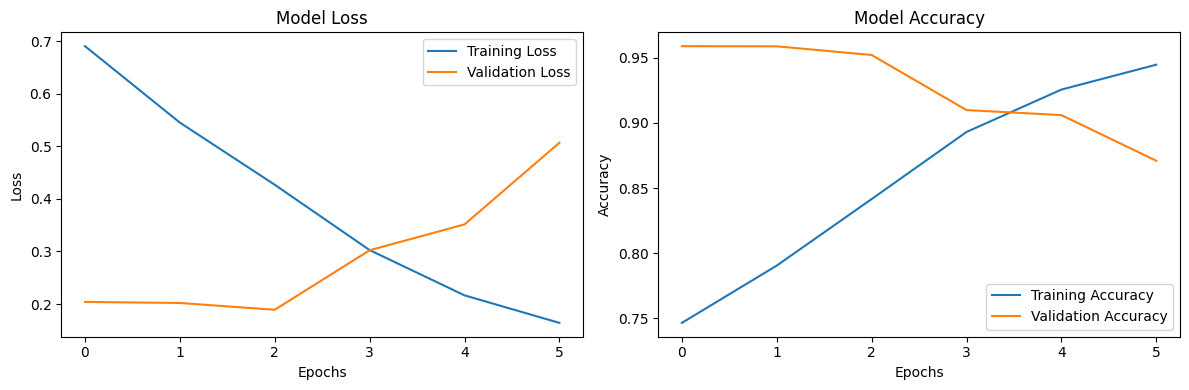

In [26]:
# Changing the  batch size to 64

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(word_bag_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(word_bag_train, y_train_encoded, epochs=30, batch_size=64,validation_split=0.1,callbacks=[early_stopping])
plot_graph(history)

The batch size  = 256 provides a good graph for our data.

In [28]:
import pickle
# saving the optimal model and vectorizer
model.save("/content/drive/MyDrive/ML/model_1_128_256.h5")
file_path = '/content/drive/MyDrive/ML/vectorizer_data_256.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(vectorizer_data, file)

# Testing

Testing custom text phrase in this section, to manually check edge cases.

In [30]:
file_path = '/content/drive/MyDrive/ML/vectorizer_data_256.pkl'
with open(file_path, 'rb') as file:
    loaded_vectorizer_data = pickle.load(file)
model = tf.keras.models.load_model("/content/drive/MyDrive/ML/model_1_128_256.h5")



# Testing the data.
text = "Awesome Course"

len_text = len(text)
word_count = len(text.split())# Creating a DataFrame
data = {
    'Text': [text]
}

df = pd.DataFrame(data)
df = data_preprocessing(df)


# Convert to DataFrame
bow_test,_= bag_of_words(df,'Text',None,True,loaded_vectorizer_data)

# Check if the shape matches the expected input shape for your model
print("Shape of the transformed test data:", bow_test.shape)

predictions = model.predict(bow_test.values)
print(predictions)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Shape of the transformed test data: (1, 8000)
1/1 [==============================] - 0s 58ms/step
[[3.9609193e-07 1.9862828e-05 1.8702060e-04 5.6938903e-04 7.1001232e-02
  9.2822212e-01]]
[5]


# Evaluation on Test Data